In [74]:
from pathlib import Path
from imageio import imwrite
import rasterio
import numpy as np
import numpy as np
from tqdm import tqdm
import rasterio

> For Potsdam, 18 out of the 24 images are selected for model training. \
> The tile 04-12 is discarded due to possible mislabelling. \
> The remaining 5 images (with tile IDs 02-12, 03-12, 05-12, 06-12 and 07-12) are employed for the validation set.

> Images are cropped into 512 × 512 patches for Potsdam and into 256 × 256 for Vaihingen in a non-
> overlapping fashion for the model training and validation.

In [75]:
ROOT = Path('.').resolve().parent

DATASET_DIR = ROOT / "datasets"
POTSDAM_DIR = DATASET_DIR / "Potsdam"
assert POTSDAM_DIR.exists(), f"Potsdam dataset not found in {POTSDAM_DIR}"

In [ ]:
ortho = POTSDAM_DIR / "2_Ortho_RGB"
labels = POTSDAM_DIR / "5_Labels_for_participants"

# LABEL_POSTFIX = '_label_noBoundary' # 5...no_border
LABEL_POSTFIX = '_label'

In [77]:
ortho_tifs = sorted(ortho.glob("*.tif"))
print(len(ortho_tifs))

labels_tifs = sorted(labels.glob("*.tif"))
print(len(labels_tifs))

38
24


In [86]:
ortho_tifs_filtered = [o for o in ortho_tifs if any(o.stem.replace("_RGB", LABEL_POSTFIX) == l.stem for l in labels_tifs)]
print(f"Filtered ortho_tifs: {len(ortho_tifs_filtered)}")

Filtered ortho_tifs: 24


In [87]:
def filter_tiles(ortho, label) -> int:
    """ 0 to train, 1 to val, -1 to discard """

    tile_id = "_".join(ortho.stem.split("_")[2:4])

    if tile_id == "4_12":
        return -1  # discard
    elif tile_id in {"2_12", "3_12", "5_12", "6_12", "7_12"}:
        return 1   # validation
    else:
        return 0   # training

In [88]:
OUT_DIR = DATASET_DIR / "Potsdam-tiles-512"
OUT_DIR.mkdir(exist_ok=True)

for ortho_tif in tqdm(ortho_tifs_filtered):
    label_tif = labels / ortho_tif.name.replace("_RGB", LABEL_POSTFIX)

    split = filter_tiles(ortho_tif, label_tif)
    if split == -1:
        continue

    split_dir = "train" if split == 0 else "val"
    out_ortho_dir = OUT_DIR / split_dir / "images"
    out_label_dir = OUT_DIR / split_dir / "labels"
    out_ortho_dir.mkdir(parents=True, exist_ok=True)
    out_label_dir.mkdir(parents=True, exist_ok=True)

    with rasterio.open(ortho_tif) as ortho_ds, rasterio.open(label_tif) as label_ds:
        width = ortho_ds.width
        height = ortho_ds.height

        patch_size = 512
        for i in range(0, width, patch_size):
            for j in range(0, height, patch_size):
                work_i, work_j = i, j

                # Handle edge cases (cropping last tile)
                if not i + patch_size <= width:
                    work_i = width - patch_size
                if not j + patch_size <= height:
                    work_j = height - patch_size

                # Read data
                # rasterio returns (Channels, Height, Width)
                ortho_patch = ortho_ds.read(window=rasterio.windows.Window(work_i, work_j, patch_size, patch_size))
                label_patch = label_ds.read(window=rasterio.windows.Window(work_i, work_j, patch_size, patch_size))

                out_ortho_path = out_ortho_dir / f"{ortho_tif.stem}_x{work_i}_y{work_j}.png"
                out_label_path = out_label_dir / f"{label_tif.stem}_x{work_i}_y{work_j}.png"

                # --- PROCESS ORTHO PHOTO ---
                # Transpose to (H, W, C)
                ortho_patch_img = ortho_patch.transpose(1, 2, 0)
                if ortho_patch_img.dtype != 'uint8':
                    ortho_patch_img = (ortho_patch_img / ortho_patch_img.max() * 255).astype('uint8')
                
                imwrite(str(out_ortho_path), ortho_patch_img)

                # --- PROCESS LABELS (RGB -> 0-N Integers) ---
                # 1. Transpose (3, H, W) -> (H, W, 3)
                # We slice [:3] just in case there is a 4th Alpha band
                label_rgb = label_patch[:3, :, :].transpose(1, 2, 0)

                # 2. Create blank mask (H, W)
                mask = np.zeros(label_rgb.shape[:2], dtype=np.uint8)

                # 3. Map Colors to Integers
                # Impervious surfaces (White) -> 0
                mask[np.all(label_rgb == (255, 255, 255), axis=-1)] = 0
                # Building (Blue) -> 1
                mask[np.all(label_rgb == (0, 0, 255), axis=-1)] = 1
                # Low vegetation (Cyan) -> 2
                mask[np.all(label_rgb == (0, 255, 255), axis=-1)] = 2
                # Tree (Green) -> 3
                mask[np.all(label_rgb == (0, 255, 0), axis=-1)] = 3
                # Car (Yellow) -> 4
                mask[np.all(label_rgb == (255, 255, 0), axis=-1)] = 4
                # Clutter/Background (Red) -> 5
                mask[np.all(label_rgb == (255, 0, 0), axis=-1)] = 5

                # 4. Save Mask
                imwrite(str(out_label_path), mask)

100%|██████████| 24/24 [05:50<00:00, 14.61s/it]


In [94]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [ ]:
postdam_static = DATASETS_DIR/'Potsdam-static'
df_classes = pd.read_csv(postdam_static/'classes.csv')
df_classes

In [ ]:
def hex2rgb(hex_color):
    if isinstance(hex_color, tuple) or isinstance(hex_color, list):
        return tuple(hex_color)
    if hex_color.startswith('#'):
        hex_color = hex_color.lstrip('#')
        t = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    else:
        t = tuple(int(x.strip()) for x in hex_color.strip('()').split(','))
    return t

ssd_cmap = ListedColormap(
    df_classes['color'].apply(lambda x: np.array(hex2rgb(x))/255.0).to_list(),
    name='skyscapes',
    N = len(df_classes)
) 

potsdam_plot_kwargs = {
    'vmin': 0,
    'vmax': 10,  # Align with tab10's range
    'cmap': ssd_cmap
}

potsdam_legend_kwargs = {
    'handles': [
        Patch(color=potsdam_plot_kwargs['cmap'](i), label=name) 
        for i, name in enumerate(df_classes.name.values)
    ],
    'bbox_to_anchor': (1.05, 1),
    'loc': 'upper left',
    'borderaxespad': 0.,
}

Unique values in label image: [0 1 2 3 4 5]


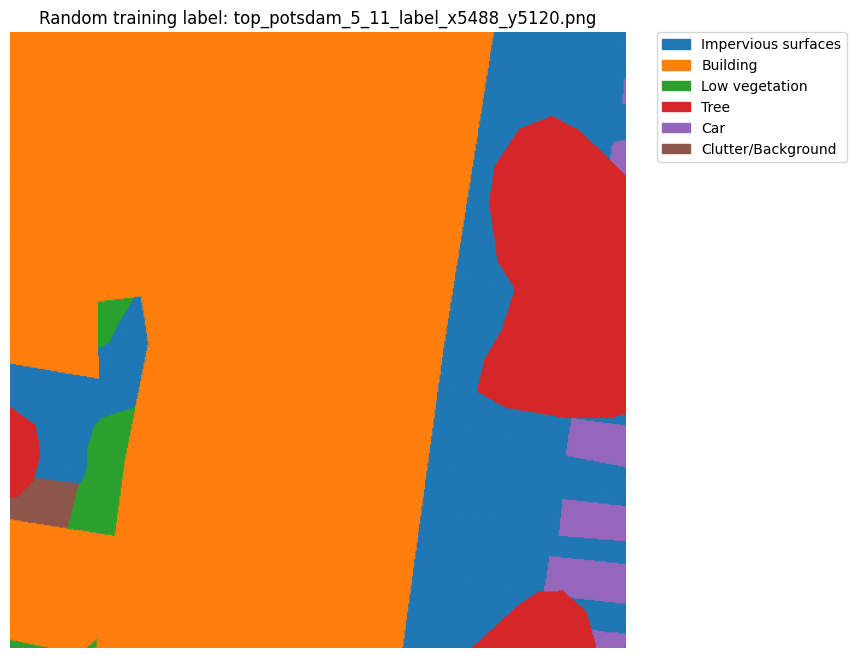

In [95]:
import random
import numpy as np
import cv2

# Get all training label paths
train_label_dir = OUT_DIR / "train" / "labels"
train_label_paths = list(train_label_dir.glob("*.png"))

# Pick a random label file
random_label_path = random.choice(train_label_paths)
# Load the label image
random_label_img = cv2.imread(str(random_label_path), cv2.IMREAD_GRAYSCALE)

print("Unique values in label image:", np.unique(random_label_img))

plt.figure(figsize=(10, 8))
plt.imshow(random_label_img, **potsdam_plot_kwargs)
plt.legend(**potsdam_legend_kwargs)
plt.title(f"Random training label: {random_label_path.name}")
plt.axis('off')

plt.show()